# SARIMA: Seasonal Autoregressive Integrated Moving Average

### Importing Relevant Packages

In [1]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from itertools import product

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [10 , 7.5]

# Revisiting Quarterly J&J EPS Data

When we viewed the dataset in previous notebooks, we did see some seasonality so we will see if applying the SARIMA model we can eliminate it. 

In [4]:
data = pd.read_csv('data/jj.csv')
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


### Plotting the Data

We can see the seasonality here. 

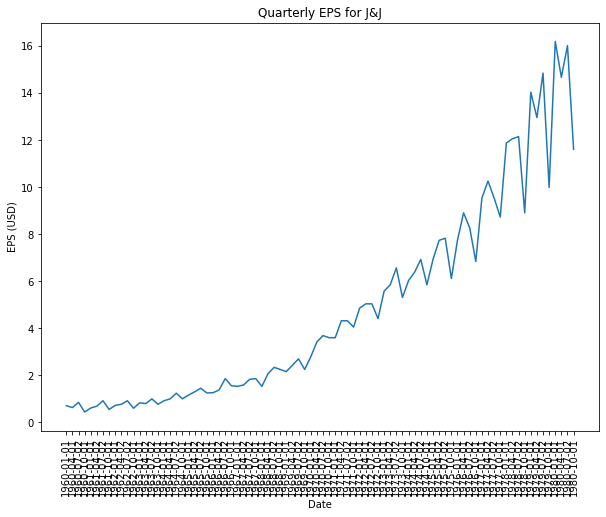

In [8]:
plt.plot(data['date'], data['data']);
plt.title('Quarterly EPS for J&J')
plt.xlabel('Date')
plt.ylabel('EPS (USD)')
plt.xticks(rotation = 90)
plt.show();

### Addressing the Seasonality (Skipping ACF / PACF)

We are going to use the log difference here to achieve stationarity within the dataset. Again, through differencing we lose the first datapoint. 

In [9]:
data['data_tr_1'] = np.log(data['data'])
data['data_tr_1'] = data['data_tr_1'].diff()

data.head()

,date,data,data_tr_1
0,1960-01-01,0.71,NaN
1,1960-04-01,0.63,-0.119545
2,1960-07-02,0.85,0.299517
3,1960-10-01,0.44,-0.658462
4,1961-01-01,0.61,0.326684


### Plotting Differenced Data

After differencing, indexing past the first row is a MUST, as the first row becomes a NaN value as a result of differencing.

Although we have tested this dataset for stationarity in previous notebooks and have come to the conclusion that it is stationary, it still is evidence that there is a pattern in variance as the ends both have high spikes and the middle has smaller variance. 

Because of this we are going to take a seasonal difference. 

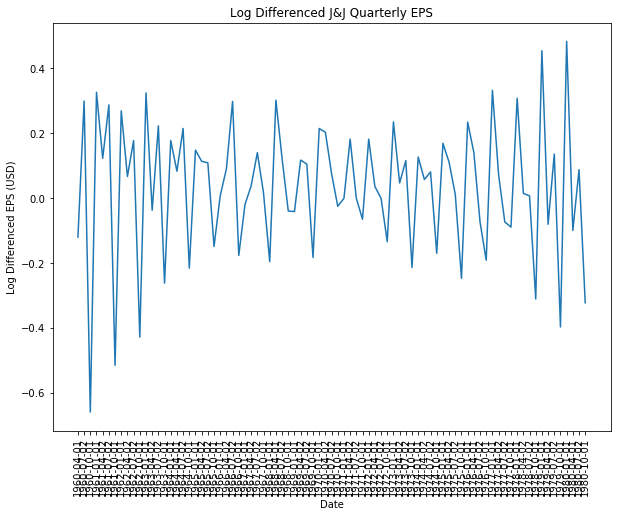

In [18]:
plt.plot(data['date'][1:], data['data_tr_1'][1:])
plt.title('Log Differenced J&J Quarterly EPS')
plt.xlabel('Date')
plt.ylabel('Log Differenced EPS (USD)')
plt.xticks(rotation = 90)
plt.show();

### Taking a Seasonal Difference

Since we are dealing with seasonal data, the parameter m will be equal to 4. The first 5 results of the seasonally differenced column become NaN values. This is because we are using 4 as the m value so it affects 4 values after the first valid data_tr_1 value. 

In [14]:
data['data_tr_2'] = data['data_tr_1'][1:].diff(4)
data.head(15)

,date,data,data_tr_1,data_tr_2
0,1960-01-01,0.71,NaN,NaN
1,1960-04-01,0.63,-0.119545,NaN
2,1960-07-02,0.85,0.299517,NaN
3,1960-10-01,0.44,-0.658462,NaN
4,1961-01-01,0.61,0.326684,NaN
5,1961-04-02,0.69,0.123233,0.242778
6,1961-07-02,0.92,0.287682,-0.011834
7,1961-10-01,0.55,-0.514455,0.144006
8,1962-01-01,0.72,0.269333,-0.057351
9,1962-04-02,0.77,0.067139,-0.056093


### Plotting this Transformation

We can see that with the seasonal differencing the variance is much more stable over the entire dataset. 

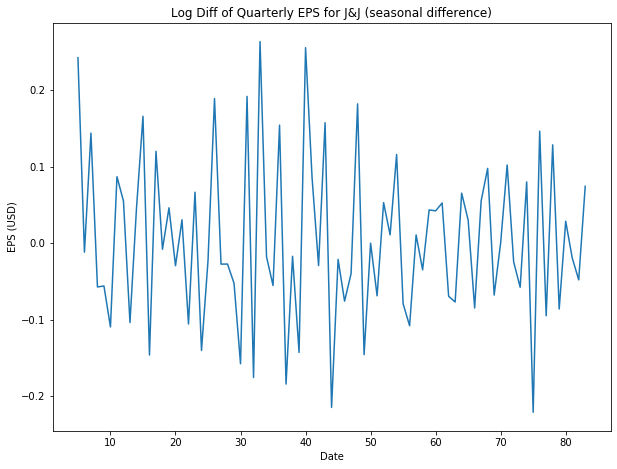

In [29]:
plt.plot(data['data_tr_2'])
plt.title('Log Diff of Quarterly EPS for J&J (seasonal difference)')
plt.xlabel('Date')
plt.ylabel('EPS (USD)')
plt.show();

### Testing for Stationarity with AD Fuller

P-value is below .05 so we can say that the dataset is stationary. 

In [30]:
ad_fuller_result = adfuller(data['data_tr_2'][5:])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.630805109914263
p-value: 5.72157869513621e-09


### ACF & PACF

We are looking at these to see if we can derive an order from them. 

From ACF we see that there aren't significant points after line one. The same is true for PACF. The sinusoidal pattern is present in both so we can't derive anything from these. 

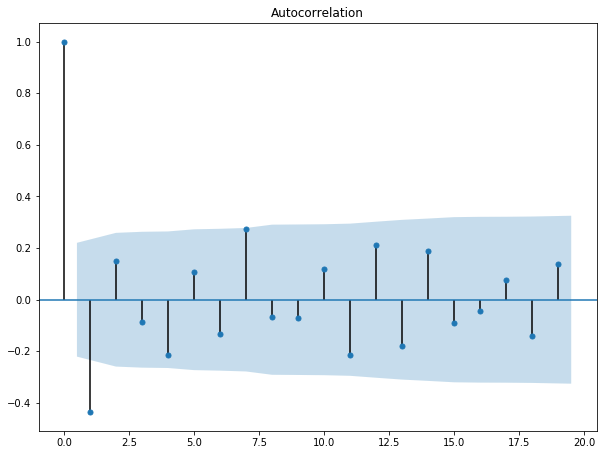

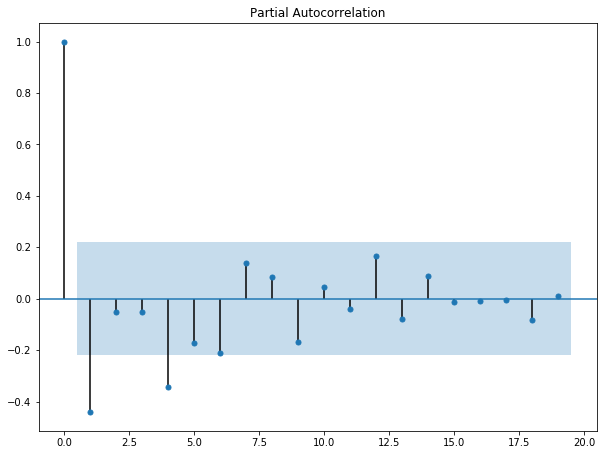

In [32]:
plot_acf(data['data_tr_2'][5:]);
plot_pacf(data['data_tr_2'][5:]);

### Writing a Function to Find the Correct Order Params

In [34]:
def optimize_SARIMA(endog, parameters_list, d, D, s):
    '''
        Returns dataframe with params and corresponding AIC.
        
        endog - the observed variable
        parameters_list - list with (p,q,P,Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of a season
    '''
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(endog,
                            order=(param[0], d, param[1]),
                            seasonal_order = (param[2], D, param[3], s),
                            simple_differencing = False).fit(disp = False)
        except:
                continue
        
        aic = model.aic
        results.append([param, aic])
    
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending = True).reset_index(drop=True)
    
    return result_df

Defining the ranges. d = 1 and D = 1 because we differenced both of these once?

In [37]:
p = range(0,4,1)
d = 1 
q = range(0,4,1)
P = range(0,4,1)
D = 1
Q = range(0,4,1)
s = 4

parameters = product(p,q,P,Q)
parameters_list = list(parameters)

print(len(parameters_list))
print(parameters_list[5:])

256
[(0, 0, 1, 1), (0, 0, 1, 2), (0, 0, 1, 3), (0, 0, 2, 0), (0, 0, 2, 1), (0, 0, 2, 2), (0, 0, 2, 3), (0, 0, 3, 0), (0, 0, 3, 1), (0, 0, 3, 2), (0, 0, 3, 3), (0, 1, 0, 0), (0, 1, 0, 1), (0, 1, 0, 2), (0, 1, 0, 3), (0, 1, 1, 0), (0, 1, 1, 1), (0, 1, 1, 2), (0, 1, 1, 3), (0, 1, 2, 0), (0, 1, 2, 1), (0, 1, 2, 2), (0, 1, 2, 3), (0, 1, 3, 0), (0, 1, 3, 1), (0, 1, 3, 2), (0, 1, 3, 3), (0, 2, 0, 0), (0, 2, 0, 1), (0, 2, 0, 2), (0, 2, 0, 3), (0, 2, 1, 0), (0, 2, 1, 1), (0, 2, 1, 2), (0, 2, 1, 3), (0, 2, 2, 0), (0, 2, 2, 1), (0, 2, 2, 2), (0, 2, 2, 3), (0, 2, 3, 0), (0, 2, 3, 1), (0, 2, 3, 2), (0, 2, 3, 3), (0, 3, 0, 0), (0, 3, 0, 1), (0, 3, 0, 2), (0, 3, 0, 3), (0, 3, 1, 0), (0, 3, 1, 1), (0, 3, 1, 2), (0, 3, 1, 3), (0, 3, 2, 0), (0, 3, 2, 1), (0, 3, 2, 2), (0, 3, 2, 3), (0, 3, 3, 0), (0, 3, 3, 1), (0, 3, 3, 2), (0, 3, 3, 3), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 0, 2), (1, 0, 0, 3), (1, 0, 1, 0), (1, 0, 1, 1), (1, 0, 1, 2), (1, 0, 1, 3), (1, 0, 2, 0), (1, 0, 2, 1), (1, 0, 2, 2), (1, 0, 2, 3), (

Now we can run it. 

In [38]:
result_df = optimize_SARIMA(data['data'], parameters_list, 1, 1, 4)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(1, 2, 3, 1)",16.000000
1,"(2, 3, 0, 0)",92.586616
2,"(2, 3, 1, 0)",93.983615
3,"(2, 3, 0, 1)",94.130945
4,"(3, 3, 0, 0)",94.469704
...,...,...
251,"(0, 0, 3, 1)",144.211575
252,"(0, 0, 3, 3)",145.086500
253,"(0, 0, 2, 3)",145.465207
254,"(0, 0, 3, 2)",145.563923


In [40]:
best_model = SARIMAX(data['data'], order=(2,1,3), seasonal_order = (0,1,0,4), simple_differencing = False)
res = best_model.fit(disp=False)

print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               data   No. Observations:                   84
Model:             SARIMAX(2, 1, 3)x(0, 1, [], 4)   Log Likelihood                 -40.293
Date:                            Mon, 23 May 2022   AIC                             92.587
Time:                                    13:57:13   BIC                            106.803
Sample:                                         0   HQIC                            98.282
                                             - 84                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4845      0.116    -12.817      0.000      -1.712      -1.257
ar.L2         -0.7902      0.131   

### Residual Analysis

The residuals appear to be normal.

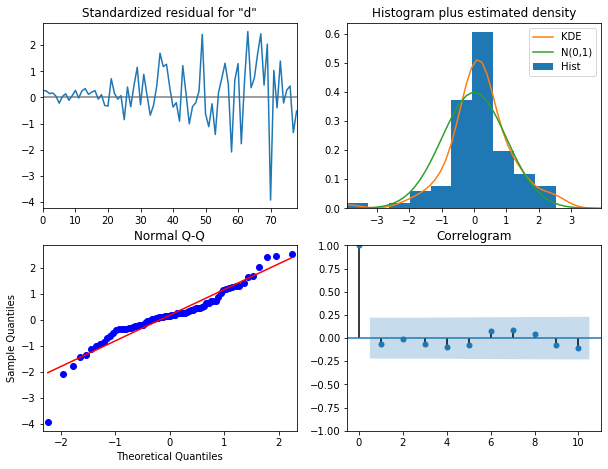

In [42]:
res.plot_diagnostics();

They're normal so we can use the model to make predictions / forecasts. 

The predictions are similar to what we got previously with ARIMA. So, we're going to get the predictions and find the MSE (Mean Squared Error)

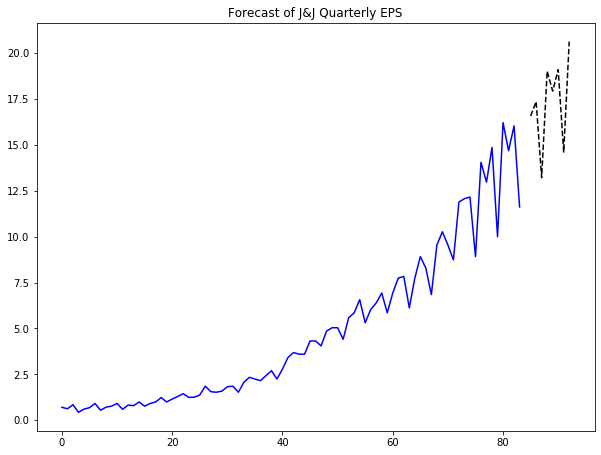

In [43]:
n_forecast = 8
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()
ax.plot(data['data'], 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of J&J Quarterly EPS')
plt.show()

### MSE Calculation

In [44]:
data['model'] = predict.predicted_mean
data.head(15)

,date,data,data_tr_1,data_tr_2,model
0,1960-01-01,0.71,NaN,NaN,0.000000
1,1960-04-01,0.63,-0.119545,NaN,0.710000
2,1960-07-02,0.85,0.299517,NaN,0.630000
3,1960-10-01,0.44,-0.658462,NaN,0.850000
4,1961-01-01,0.61,0.326684,NaN,0.795000
5,1961-04-02,0.69,0.123233,0.242778,0.530000
6,1961-07-02,0.92,0.287682,-0.011834,0.804976
7,1961-10-01,0.55,-0.514455,0.144006,0.482697
8,1962-01-01,0.72,0.269333,-0.057351,0.645377
9,1962-04-02,0.77,0.067139,-0.056093,0.748628


In [45]:
mse = mean_squared_error(data['data'], data['model'])
print(f'MSE: {mse}')

MSE: 0.15612822132463228


Previously with ARIMA, we got an MSE of 0.16, so this is a lower MSE, and therefore a superior model. Additionally we could clearly see seasonality and this model addresses seasonality. 

### For fun, Let's plot modeled versus original data. 

These lines are almost identical. Nice! 

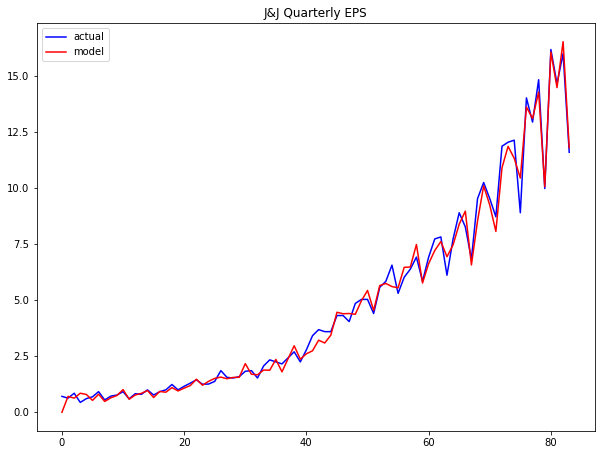

In [48]:
plt.plot(data['data'], color = 'blue', label = 'actual')
plt.plot(data['model'], color='red', label = 'model')
plt.legend(loc='best')
plt.title('J&J Quarterly EPS')
plt.show();